# Detecting DNS Exfiltration via Traffic Analytics
By Herbert Maosa  
Cybersecurity Consultant | PhD | CISSP | OSCP

---

***"Most networks let DNS traffic pass without a second thought - and that's exactly what attackers are counting on."***  

**DNS exfiltration** is a stealthy cyberattack where sensitive data - *passwords, source code, or trade secrets* - is smuggled out of a network inside DNS queries. Because DNS is rarely blocked or scrutinized, attackers encode payloads into domain lookups and quietly bypass firewalls.
This data leakage can include passwords, intellectual property, or other confidential information, sent as parts of DNS query names or payloads. Detecting DNS exfiltration requires looking for unusual patterns such as:
- Excessively long or random-looking domain names
- High volumes of DNS queries to suspicious domains
- Anomalies in query types and response behavior

In this post, we'll dive into hands-on analytics and visualizations using real PCAP data - and expose how stealthy DNS traffic can reveal a breach in progress.

---
## Imports

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../Scripts"))

In [2]:
import json
import pandas as pd
import math
import ipywidgets as widgets
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display
import seaborn as sns
import tldextract
from ipyfilechooser import FileChooser
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from process_pcap import process_dns
from dns_utils import shannon_entropy, map_dns_subdomains

sns.set(style='whitegrid')
plt.close('all')
warnings.filterwarnings("ignore", message=".*use_inf_as_na.*")

---
## 1. Dataset and Parsing
For this Notebook, we analyze the [CIC-Bell-DNS-EXF-2021 dataset](https://www.unb.ca/cic/datasets/dns-exf-2021.html) by the Canadian Institute of Cyber Security- a well-known benchmark in cybersecurity research, particularly for DNS exfiltration detection. This dataset is provided in two formats:
- A CSV file with ~30 pre-engineered features for machine learning
- A raw PCAP file containing full packet captures.

Although the PCAP includes other protocols, we focused exclusively on DNS traffic to investigate potential exfiltration activity.
The processed output is stored in a structured JSON file, which we load into a Pandas DataFrame for analysis.
You can find the PCAP parser and dataset link on this project's GitHub page

Above we have defined some utility functions that we will user later during the analysis. The *shannon_entropy* function will be discussed in a subsequent article for performing statistical analysis and machine learning. The *map_dns_function* extracts the subdomains from the top level domain (TLD), and maps all such subdomains to their root domain.  
We will use this to perform domain name cardinality.

In [3]:
pcap_file = '../parsed_output/dns_traffic.json' # specify the location of your parsed JSON files

To simplify the notebook and separate concerns, we’ve moved the heavy lifting code—such as PCAP ingestion and DNS log processing—into dedicated helper scripts. These scripts handle tasks like parsing PCAP files and transforming the DNS traffic into an analyzable format.

Only the essential code for visualization and analysis is retained in the notebook for clarity. You can access all helper scripts on the project's GitHub page.

The notebook reads a parsed .pcap file (previously converted to JSON format using our pcap_parser.py script) and performs a few preprocessing steps. Specifically, it:

- Adds two new features:
- qname_length: the length of each DNS query name
- qname_entropy: a measure of randomness (Shannon entropy) of the query name
- Explodes the questions and answers arrays to flatten the payload into a row-wise DataFrame

In [4]:
df, empty_q_df = process_dns(pcap_file)
df.head(3) if df is not None else "Upload a file to begin analysis."

,timestamp,src_ip,dst_ip,ip_protocol,ip_header_length,packet_size,type,src_port,src_service,dst_port,...,id,qr,opcode,rcode,answers,qname,qtype,qclass,qname_length,qname_entropy
0,2020-11-24 00:32:38.062066,192.168.20.38,8.8.8.8,UDP,20,75,other,52433,None,53,...,53331,0,0,0,[],v10.events.data.microsoft.com.,1,1,30,3.802910
1,2020-11-24 00:32:38.086978,8.8.8.8,192.168.20.38,UDP,20,193,other,53,domain,52433,...,53331,1,0,0,[],v10.events.data.microsoft.com.,1,1,30,3.802910
2,2020-11-24 00:37:20.374794,192.168.20.38,8.8.8.8,UDP,20,56,other,51698,None,53,...,11770,0,0,0,[],dns.google.,1,1,11,2.913977


---
## 2. Static Analysis
Static analysis focuses on features based on what is being queried or the responses received. IThis is data that can be directly extracted from the DNS Header, or query and response payloads. In this blog we examine:
- DNS response codes (RCODEs)
- Query Length Distribution.
- Subdomain cardinality (how many subdomains per root domain)
- Most frequently queried domain names

---
### 2.1 RCODE Analysis
In DNS, the **rcode** field in a response indicates the result of the query. Analyzing these response codes helps identify suspicious or anomalous behavior, especially in the context of DNS exfiltration.

Common RCODE Values:

**0** — NoError: Normal response

**1** — FormErr: Malformed query

**2** — ServFail: Server failure

**3** — NXDomain: Domain does not exist

**5** — Refused: Query denied by server.
### Why RCODE Matters in Exfiltration Analysis
In many DNS exfiltration campaigns, attackers use **RCODE=0** (NoError) responses - but without returning any actual answers in the payload. This combination is unusual and may indicate:
A stealth tunnel that confirms query receipt without revealing actual records
DNS servers under attacker control that acknowledge all queries without serving real data

Conversely, repeated NXDOMAIN (**RCODE=3**) or Refused (**RCODE=5**) errors may signal probing or command-and-control attempts via non-existent domains.
DNS queries that return `rcode=0` (NoError) but have empty `answers` are suspicious. Here we break down DNS responses by RCODE to understand response patterns.
In Our Dataset
We broke down the frequency of RCODEs across the dataset to identify patterns. As shown in the chart below, the vast majority of queries returned NoError - but with empty answer sections, raising suspicion of covert behavior.

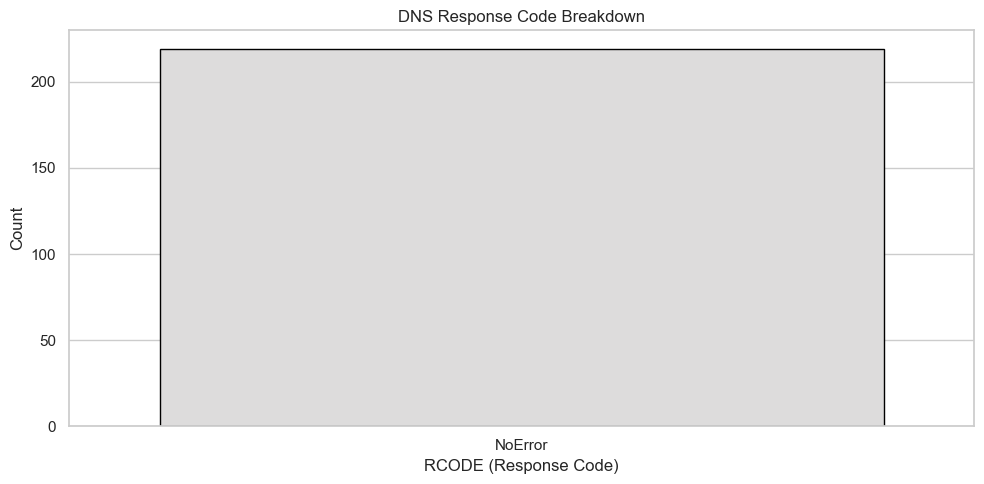

In [5]:
# Filter DNS responses only
responses_df = df[df["qr"] == 1].copy()

# Map RCODEs to descriptive names
rcode_labels = {
    0: "NoError",
    1: "FormErr",
    2: "ServFail",
    3: "NXDomain",
    4: "NotImp",
    5: "Refused"
}
responses_df["rcode_name"] = responses_df["rcode"].map(rcode_labels).fillna("Other")

# Count occurrences
rcode_counts = responses_df["rcode_name"].value_counts().reset_index()
rcode_counts.columns = ['rcode_name', 'count']
rcode_counts["hue"] = rcode_counts["rcode_name"]  # Dummy hue to suppress warning

# Plot with hue and no legend
plt.figure(figsize=(10, 5))
sns.barplot(
    data=rcode_counts,
    x='rcode_name', y='count',
    hue='hue', palette='coolwarm', edgecolor='black', legend=False
)
plt.title("DNS Response Code Breakdown")
plt.xlabel("RCODE (Response Code)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('../Images/rcode_analysis.png')
plt.show()

**Figure 2.1:** Breakdown of DNS response codes (RCODE). The overwhelming majority of responses are `NoError` (rcode=0), yet many have *empty answer sections* — a potential sign of DNS-based data exfiltration.

This result shows that the  majority of responses with RCODE=0 (NoError) have no actual answers. This is a known pattern in DNS exfiltration, where the attacker's server acknowledges queries to maintain stealth — without serving real DNS data. We can already flag these queries as suspicious, warranting further investigation.

---
### 2.2 DNS Query Length Distribution

### Why This Matters
Analyzing DNS query length and entropy helps detect abnormal patterns. Long or high-entropy query names may contain encoded or obfuscated data, often used in DNS-based data exfiltration or tunneling attacks.

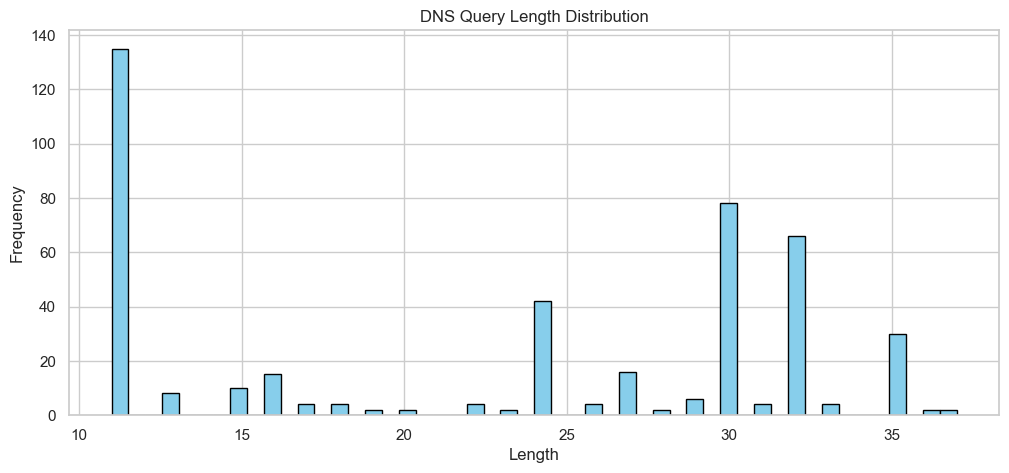

In [6]:
plt.figure(figsize=(12, 5))
plt.hist(df['qname_length'], bins=50, color='skyblue', edgecolor='black')
plt.title("DNS Query Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig('../Images/query_len.png')
plt.show()

**Figure 2.2:** Distribution of DNS query lengths (`qname_length`). Abnormally long query names may suggest data encoding for exfiltration, while uniform lengths could indicate automated beaconing or command-and-control activity.

The distribution of query lengths reveals structural irregularities in DNS traffic. In typical user-driven DNS usage, query lengths vary widely depending on websites and services accessed. However, in our dataset:

We observe a peak at unusually long query lengths, which may suggest that data is being encoded directly into the query name.  
If there is a tight cluster of queries all around the same length, it may point to automated scripts or malware generating structured, periodic DNS requests.

These findings reinforce earlier indicators of DNS misuse — particularly when correlated with high subdomain cardinality or suspicious destination domains, as is the case with our dataset

---
### 2.3 Top Queried Domain Names
Beyond analyzing subdomain patterns, it's equally important to examine which domains are being queried most frequently. Domains with an unusually high number of total queries - especially when paired with high subdomain cardinality - are prime suspects for data exfiltration.
These domains often:
- Receive thousands of queries within short periods
- Appear obscure, newly registered, or unrelated to business activity
- Encode data into subdomains to bypass detection

The code below queries our dataframe for all records with no errors in the response ```(qr ==1 )``` yet the response payload is empty ```(rcode == 0 )```. Then we count such responses for each queried domain name and plot the result.

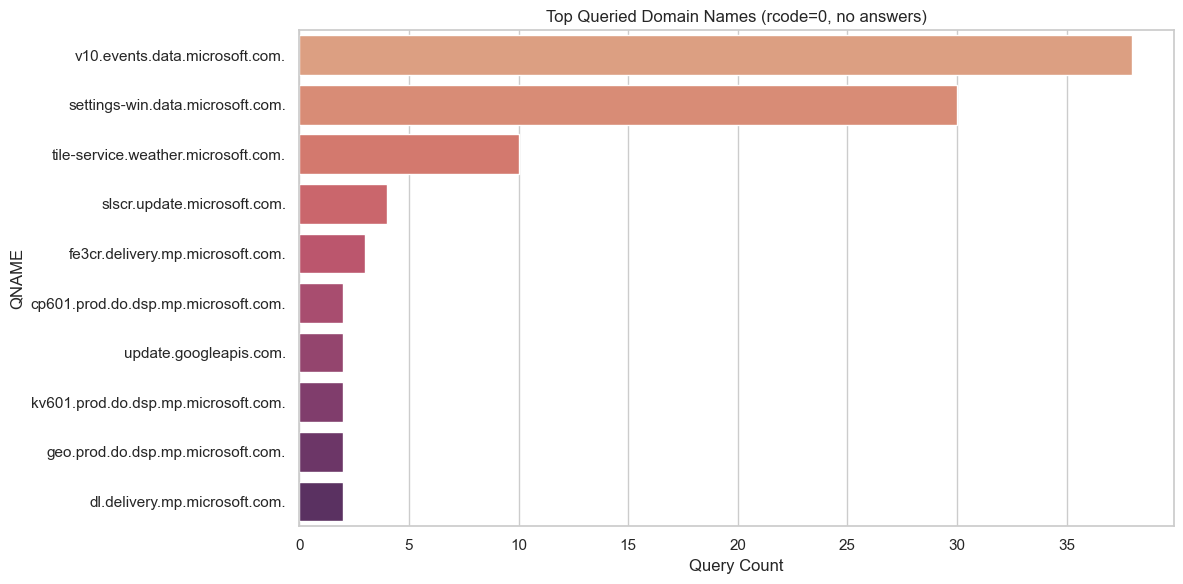

In [7]:
# Filter to rcode=0 responses with empty answers
empty_success_responses = df[
    (df['qr'] == 1) &
    (df['rcode'] == 0) &
    (df['answers'].apply(lambda a: isinstance(a, list) and len(a) == 0))
].copy()

# Drop rows without qname
empty_success_responses = empty_success_responses[empty_success_responses['qname'].notna()].copy()

# Show top qnames
top_qnames = empty_success_responses['qname'].value_counts().head(10)
top_qnames_df = top_qnames.reset_index()
top_qnames_df.columns = ['qname', 'count']
top_qnames_df['hue'] = top_qnames_df['qname']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_qnames_df, x='count', y='qname', hue='hue', palette='flare', legend=False)
plt.title("Top Queried Domain Names (rcode=0, no answers)")
plt.xlabel("Query Count")
plt.ylabel("QNAME")
plt.tight_layout()
plt.savefig('../Images/top_queried_domain_names.png')
plt.show()

**Figure 2.3:** Domains receiving the highest number of DNS queries. A high query count, especially in combination with subdomain encoding, may reveal command-and-control or exfiltration endpoints.

As the chart shows, the *'microsoft.com'* domain in our dataset has been queried with 20 different subdomain names. In many cases, benign domains rarely exhibit this behavior. Sudden spikes in subdomain diversity under a single domain - especially with high entropy - may be a strong indicator of data exfiltration in progress.

---
### 2.4 Subdomain Cardinality

Another hallmark of DNS-based exfiltration is the use of many unique subdomains under the same root domain. Attackers often encode sensitive data into subdomains — and then repeatedly query these dynamically generated names to leak information bit by bit.

For example, a root domain like malicious-domain.com might receive dozens or hundreds of queries like:

```
abc123.malicious-domain.com  
username1.password1.malicious-domain.com  
ccnumber.expirydate.ccv.9dkaei.malicious-domain.com  
```
These domains often appear random and are not typically seen in high traffic. The subdomains encode the actual data being exfiltred, either in plain text or base64encoded.

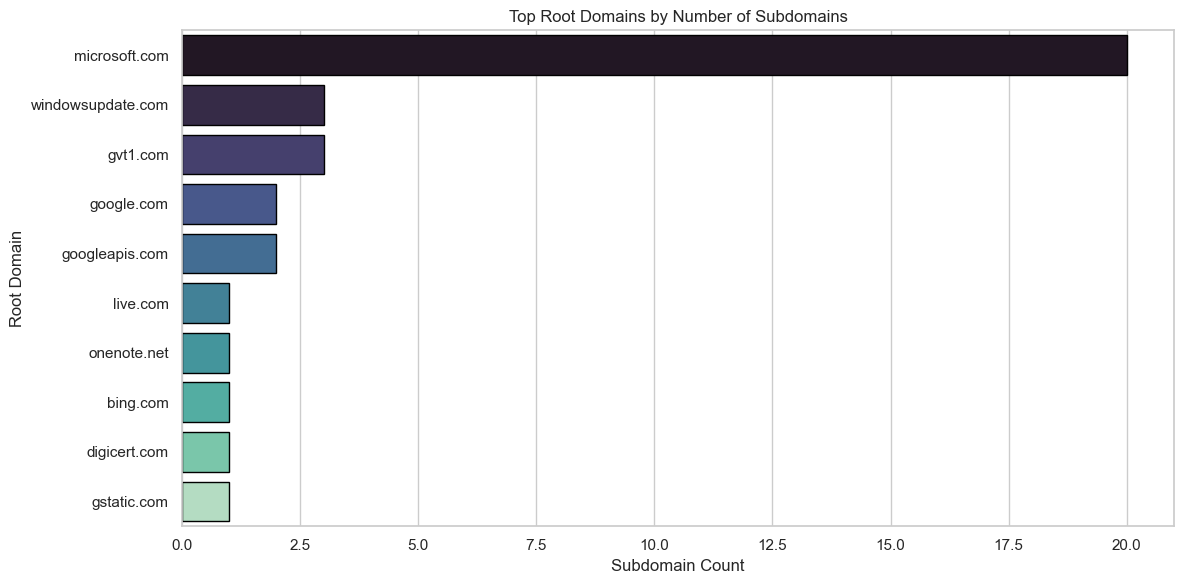

In [8]:
subdomain_map = map_dns_subdomains(df['qname'])

records = [{"root_domain": root, "subdomain_count": len(subs)} for root, subs in subdomain_map.items()]
subdomain_count_df = pd.DataFrame(records).sort_values(by="subdomain_count", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=subdomain_count_df.head(10),
    x="subdomain_count",
    y="root_domain",
    hue="root_domain", 
    palette="mako",
    edgecolor="black",
    dodge=False
)
plt.legend([],[], frameon=False)

plt.title("Top Root Domains by Number of Subdomains")
plt.xlabel("Subdomain Count")
plt.ylabel("Root Domain")
plt.tight_layout()
plt.savefig('../Images/domain_cardinality.png')
plt.show()

**Figure 2.4**: Root domains with the highest number of unique subdomains. Unusual subdomain diversity, especially for obscure domains, may suggest that DNS is being used to encode and exfiltrate data.

This chart ranks root domains by the number of distinct subdomains observed. While most domains have only 1–2 subdomains, *microsoft.com* stands out with over 20. Such high subdomain cardinality is atypical for legitimate traffic and is a well-known signature of DNS data exfiltration, where each subdomain carries a fragment of encoded data. The fact that all responses returned rcode=0 but lacked answers further strengthens the suspicion.

---
## 3. Temporal and Statistical Analysis
This analysis focuses on time series based characterlitics, for example, the time window, duration, and frequency of when the DNS activity occurs. This includes:
- Time series trends (e.g. spikes or regular intervals)
- Interarrival times between queries
These patterns help uncover **beaconing behavior, bursts of activity, or unusual timing** often associated with automated exfiltration tools.

---
### 3.1 Stacked Time Series Analysis
To uncover possible data exfiltration, we analyze the temporal distribution of DNS traffic. Specifically, we compare:

- All DNS queries over time
- Suspicious queries with rcode=0 and empty answer sections

This time-series visualization helps us spot bursts, regular intervals, or anomalous surges in suspicious traffic.
This stacked chart highlights when suspicious queries occur. Spikes in rcode=0 queries with empty answers — especially in tight bursts or repeated patterns — may signal automated beaconing or payload transfer intervals.

Look for sharp surges in red overlay (suspicious traffic) as a potential indicator of data leakage in progress.

In the code below, we resample our queries into 1 minute bins, then group them according to the bin in which they fit. Then we extract the suspicious ones based on the previous criteria where we have ```rcode = 0``` but no answers. We then plot a stacked line chart, showing the time-series distribution of the suspicius queries and all other (potentially benign) queries.

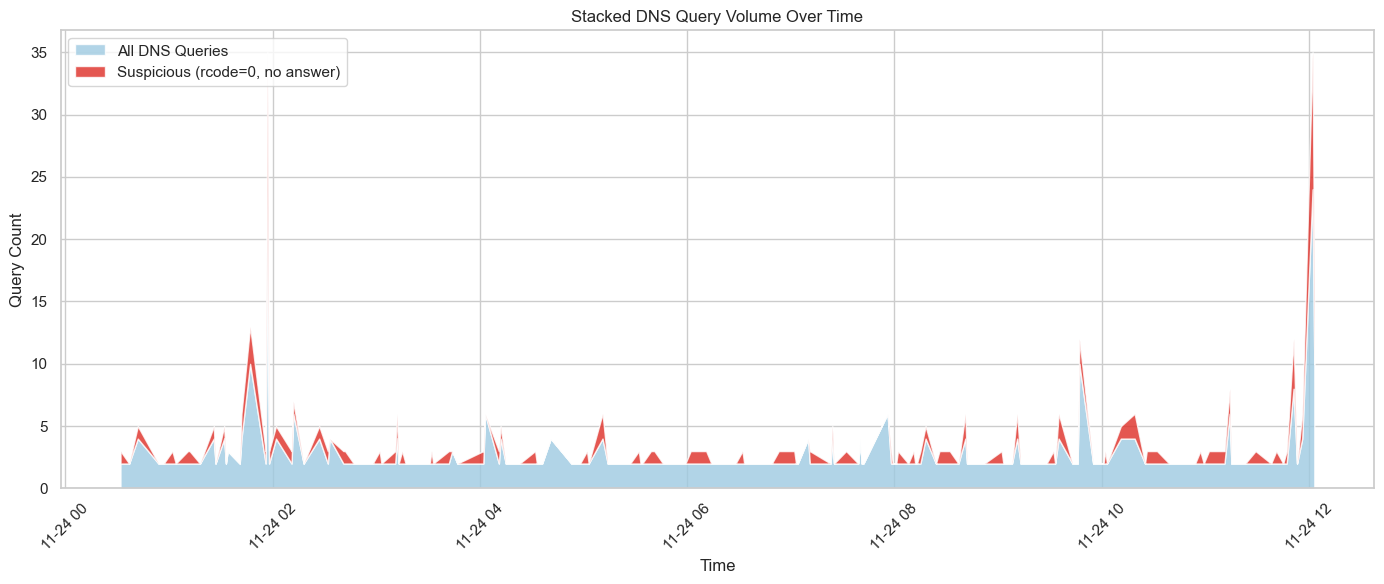

In [9]:
# Convert timestamp and group by minute
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['minute'] = df['timestamp'].dt.floor('min')

# Total DNS queries per minute
all_volume = df.groupby('minute').size().reset_index(name='all_queries')

# Filter suspicious queries: NoError responses with no answers
suspicious_df = df[
    (df['qr'] == 1) &
    (df['rcode'] == 0) &
    (df['answers'].apply(lambda a: isinstance(a, list) and len(a) == 0))
].copy()
suspicious_df['minute'] = suspicious_df['timestamp'].dt.floor('min')
suspicious_volume = suspicious_df.groupby('minute').size().reset_index(name='suspicious_queries')

# Merge and fill gaps
volume_df = pd.merge(all_volume, suspicious_volume, on='minute', how='outer').fillna(0)

# Plot stacked area chart
plt.figure(figsize=(14, 6))
plt.stackplot(
    volume_df['minute'],
    volume_df['all_queries'],
    volume_df['suspicious_queries'],
    labels=["All DNS Queries", "Suspicious (rcode=0, no answer)"],
    colors=["#9ecae1", "#de2d26"],
    alpha=0.8
)
plt.legend(loc="upper left")
plt.title("Stacked DNS Query Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Query Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../Images/stacked_query_volume.png")
plt.show()

**Figure 3.1:** Stacked time series showing total DNS queries vs. suspicious queries (`rcode=0` with no answers). Repeating bursts or periodic spikes may indicate *automated exfiltration or beaconing behavior*.

This stacked chart highlights when suspicious queries occur. Spikes in rcode=0 queries with empty answers - especially in tight bursts or repeated patterns - may signal automated beaconing or payload transfer intervals.
Look for sharp surges in red overlay (suspicious traffic) as a potential indicator of data leakage in progress.
In addition to traffic volume spikes, this chart reveals another subtle signal: periodicity.
Attackers often configure malware to exfiltrate data at regular intervals to avoid triggering volume-based alerts. These time-based patterns - sometimes referred to as beaconing behavior - can show up as:
Evenly spaced bursts of suspicious DNS queries
Consistent minute-by-minute activity, even during low-traffic periods

In our dataset, we observe such recurring intervals in the rcode=0 with no answer responses - reinforcing the likelihood of automated exfiltration mechanisms at play.

---
### 3.2 Inter-arrival Time Distribution - Beaconing Behaviour Analysis
Attackers often attempt to evade detection by spacing out DNS queries at regular intervals — a technique known as beaconing. To analyze this, we calculate the time between successive queries from the same source IP. Beaconing behavior is a common tactic used by malware to maintain communication with a command-and-control (C2) server. It typically involves a host sending out periodic, automated requests—often over DNS—to check in or receive commands. This regularity in communication timing forms the basis for detection. To identify such behavior, we begin by analyzing the distribution of time intervals between successive DNS requests.

If many queries are tightly clustered, or if they follow a repetitive pattern, it could indicate automated data exfiltration behavior.

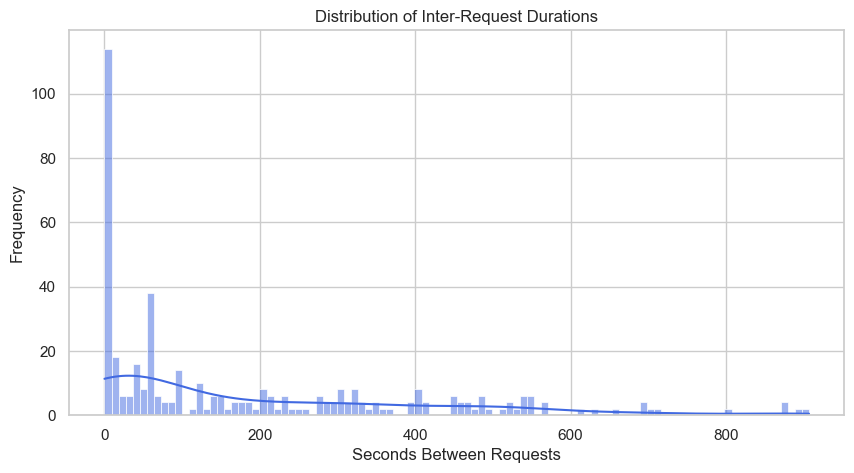

In [10]:
# Ensure timestamps are sorted by source IP and time
df = df.sort_values(by=["src_ip", "timestamp"]).reset_index(drop=True)

# Calculate the time difference between each request and the one before it (per source IP)
df['delta'] = df.groupby("src_ip")['timestamp'].diff().dt.total_seconds()

# Sort by source and time
empty_success_responses = empty_success_responses.sort_values(by=['src_ip', 'timestamp'])

# Calculate time difference from previous packet by the same src_ip
empty_success_responses['interarrival'] = empty_success_responses.groupby('src_ip')['timestamp'].diff().dt.total_seconds()

# Drop nulls (first request per src_ip)
interarrival_df = empty_success_responses.dropna(subset=['interarrival'])

# Basic distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(df['delta'].dropna(), bins=100, kde=True, color='royalblue')
plt.title("Distribution of Inter-Request Durations")
plt.xlabel("Seconds Between Requests")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig('../Images/inter-arrival-times_duration.png')
plt.show()

**Figure 3.2:** Histogram of DNS query interarrival times. Sharp peaks or evenly spaced intervals may signal regular, automated query behavior — consistent with malware beacons or data tunneling.

This distribution reveals whether traffic is bursty, periodic, or random. Peaks at regular intervals may indicate automated beaconing, while a large number of queries with very short gaps may suggest data bursts. The chart shows the behaviour per souce ip address. In our dataset, we observe both - supporting the hypothesis of controlled, possibly malicious DNS communication. Notably, we observe:

- A sharp spike at **very short intervals** (0–5 seconds), suggesting some rapid-fire or retry behavior.
- **Secondary peaks** around **30s**, **60s**, and **180s**, which may indicate repeated scheduling or automation.
- A **long tail** of less frequent, irregular intervals—typical of user-driven or system noise.

These repeated peaks suggest that at least some hosts are communicating at **periodic intervals**, a strong early indicator of potential beaconing behavior.

### 3.3 Beaconing Candidates: Statistical Analysis

To further investigate, we compute the **mean** and **standard deviation** of inter-request intervals for each host. In normal (benign) traffic, inter-request intervals tend to be irregular, resulting in a higher standard deviation. This reflects user-driven or application-triggered behavior with variable timing.
In contrast, automated or beaconing traffic often shows a low standard deviation with a consistent mean—indicating predictable, periodic queries that may signal command-and-control activity or data exfiltration.

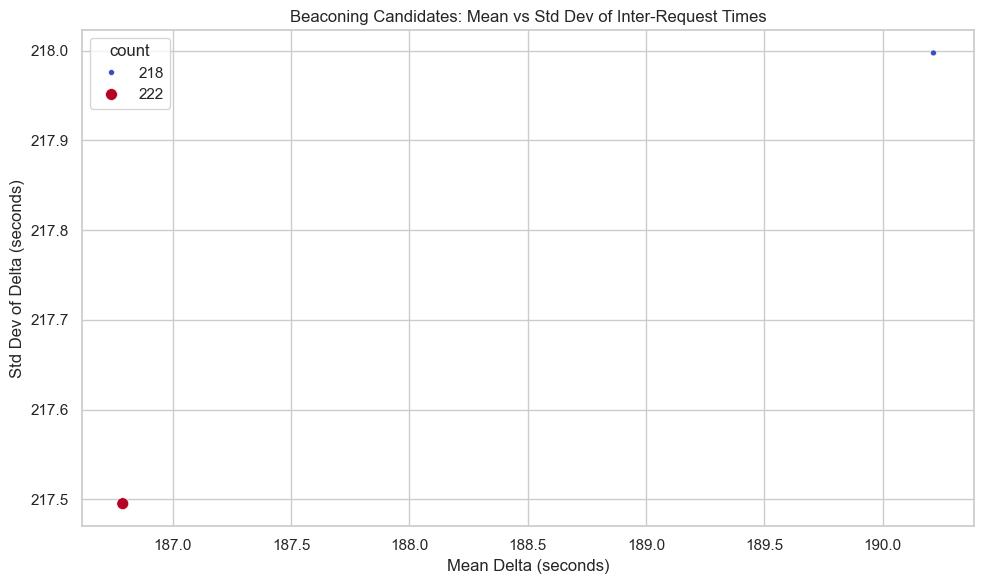

In [11]:
beacon_stats = df.groupby("src_ip")['delta'].agg(
    count="count",
    mean="mean",
    std="std"
).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=beacon_stats, x='mean', y='std', hue='count', palette='coolwarm', size='count')
plt.title("Beaconing Candidates: Mean vs Std Dev of Inter-Request Times")
plt.xlabel("Mean Delta (seconds)")
plt.ylabel("Std Dev of Delta (seconds)")
plt.grid(True)
plt.tight_layout()
plt.savefig('../Images/beaconing-candidates.png')
plt.show()

**Figure 3.3**: Beaconing Candidates based on Inter-Request Timing  

This scatter plot visualizes hosts by the mean and variability of their DNS request intervals. Each point represents a host, with the X-axis showing the average time between requests and the Y-axis showing the standard deviation. While some hosts show repeated intervals around 187–190 seconds, their high standard deviation suggests inconsistent timing. This undermines confidence in strong beaconing behavior, though such hosts may still be automated or loosely scheduled systems worth deeper inspection.

In an typical beaconing scenario, we expect:

- **Regular timing** → Low standard deviation
- **Non-trivial intervals** → Mean values in the range of 30s to several minutes

However, the hosts identified here show:

- Mean intervals around **187–190 seconds**
- Standard deviations nearly as high as the means (~217s)

This suggests **significant variability** in request timing, undermining the idea of strict periodicity. While these hosts may still be using automated processes (e.g., system jobs, loose scheduling), their behavior does **not** exhibit the tight regularity expected of **high-confidence beaconing traffic**.

Correlating the analysis from the these two charts, we note a class of hosts that exhibit **weak or noisy beaconing behavior**. Their communication intervals suggest some level of automation, but the variability indicates either:

- Legitimate background activity (e.g., scheduled tasks or telemetry), or
- Poorly implemented or jittered malware beacons

In threat hunting, such patterns are worth flagging for deeper inspection—especially when combined with indicators like domain entropy, repeated destination IPs, or abnormal query content.

---
## Conclusion: What We Learned

In this blog, we walked through a real-world example of how to detect DNS exfiltration using Python and Pandas for traffic analytics. We explored a combination of:  
### Static Features
- *RCODE patterns*, especially NoError responses with no answers
- *Query Length Distribution* - revealing data being encoded in subdomain labels.
- *Subdomain cardinality* as a proxy for data encoding activity
- *Top queried domains* to isolate suspicious focal points in traffic

### Temporal Features
- *Time series visualizations* to detect query bursts and irregularities
- *Interarrival times* to uncover signs of automated beaconing

The presence of over 20 distinct subdomains under **microsoft.com**, coupled with successful ```(rcode=0)``` DNS responses that returned no answers, strongly aligns with known DNS exfiltration techniques. This behavior is inconsistent with normal enterprise traffic and represents a credible threat indicator. Although no encoded payload decoding was attempted, the volume and nature of the queries justify flagging this activity for immediate triage or containment.

## Final Takeaways: Threat Hunting for DNS Exfiltration

- High subdomain cardinality, especially concentrated under `microsoft.com`, is anomalous and suspicious.
- DNS queries returned `rcode=0` but no answers, a signature of data-smuggling tactics.
- Timing analysis showed weak periodicity, not conclusive, but supportive when combined with other signals.
- No decoding was performed, but the structural DNS indicators meet the threshold for **likely exfiltration behavior**.

🔎 **Conclusion**: This analysis strongly suggests potential DNS exfiltration and warrants follow-up with endpoint or threat intelligence tools.


## What’s Next?
In our next post, we’ll take these handcrafted features and explore how to:
- Train machine learning models to detect DNS exfiltration automatically
- Use both supervised and unsupervised approaches
- Apply anomaly detection techniques to real PCAP datasets

Stay tuned — and in the meantime, you can grab the source code and notebook on GitHub (add your repo link here) to try it out on your own traffic captures.

---
## Dataset Reference

Lashkari, A.H., Gil, G., Mamun, M.S.I., & Ghorbani, A.A. (2021). CIC-Bell DNS EXF Dataset [Data set]. Canadian Institute for Cybersecurity.  
Available at: https://www.unb.ca/cic/datasets/dns-exf.html  
 
Samaneh Mahdavifar, Amgad Hanafy Salem, Princy Victor, Miguel Garzon, Amir H. Razavi, Natasha Hellberg, Arash Habibi Lashkari, "Lightweight Hybrid Detection of Data Exfiltration using DNS based on Machine Learning", The 11th IEEE International Conference on Communication and Network Security (ICCNS), Dec. 3–5, 2021, Beijing Jiaotong University, Weihai, China.